In [18]:
# Cargamos la librería seqeval
#https://github.com/chakki-works/seqeval
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

# Cargamos pandas
import pandas as pd
import numpy as np

# Cargamos las métricas de sklearn
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

#
import matplotlib.pyplot as plt

In [19]:
# Cargamos el archivo procesado
#df = pd.read_csv("/Users/alfredomadrid/Desktop/TFM/Analisis de error/NER/NERFinalCompleto.txt", sep='\t')
df = pd.read_csv("/Users/alfredomadrid/Desktop/TFM/Analisis de error/CLASS/CLASSFinalCompleto.txt", sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215531 entries, 0 to 215530
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   words_GS     215531 non-null  object
 1   fileId_GS    215531 non-null  object
 2   start_GS     215531 non-null  int64 
 3   end_GS       215531 non-null  int64 
 4   label_GS     215531 non-null  object
 5   words_pred   215531 non-null  object
 6   fileId_pred  215531 non-null  object
 7   start_pred   215531 non-null  int64 
 8   end_pred     215531 non-null  int64 
 9   label_pred   215531 non-null  object
dtypes: int64(4), object(6)
memory usage: 16.4+ MB


In [20]:
df

,words_GS,fileId_GS,start_GS,end_GS,label_GS,words_pred,fileId_pred,start_pred,end_pred,label_pred
0,Un,32423911_ES,0,3,O,Un,32423911_ES,0,3,O
1,hombre,32423911_ES,4,10,O,hombre,32423911_ES,4,10,O
2,de,32423911_ES,11,13,O,de,32423911_ES,11,13,O
3,36,32423911_ES,14,16,O,36,32423911_ES,14,16,O
4,años,32423911_ES,17,21,O,años,32423911_ES,17,21,O
...,...,...,...,...,...,...,...,...,...,...
215526,diagnóstico,cc_reuma8,855,866,O,diagnóstico,cc_reuma8,855,866,O
215527,de,cc_reuma8,867,869,O,de,cc_reuma8,867,869,O
215528,artritis,cc_reuma8,870,878,O,artritis,cc_reuma8,870,878,O
215529,reumatoide,cc_reuma8,879,889,O,reumatoide,cc_reuma8,879,889,O


Preparamos los archivos para su evaluación. Para ello juntamos los token que hagan referencia a una misma nota

In [21]:
df['label_GS_list'] = df.groupby(['fileId_GS'])['label_GS'].transform(lambda x: ' '.join(x))
df['label_pred_list'] = df.groupby(['fileId_GS'])['label_pred'].transform(lambda x: ' '.join(x))
df['words_list'] = df.groupby(['fileId_GS'])['words_GS'].transform(lambda x: ' '.join(x))
df = df[["fileId_GS", "label_GS_list", "label_pred_list", "words_list"]].drop_duplicates()
df

,fileId_GS,label_GS_list,label_pred_list,words_list
0,32423911_ES,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...,Un hombre de 36 años llegó al servicio de urge...
629,32605766_ES,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...,"﻿El señor G , un hombre de 43 años sin anteced..."
2085,32614251_ES,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...,﻿Una mujer de 20 años embarazada secundigesta ...
2732,S0004-06142009000100010-2,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...,Nombre : Miriam . Apellidos : Aguilar Mora . C...
3166,S0034-98872006000200011-1,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O O O ...,Nombre : Paula . Apellidos : De la Cruz Lorenz...
...,...,...,...,...
214001,cc_reuma55,O O O O O O O O O O O O O O O O O B-PACIENTE O...,O O O O O O O O O O O O O O O O O B-PACIENTE O...,Varón de 45 años . Natural de Uruguay . Vive e...
214220,cc_reuma56,O O O O O O O O O O O O O B-PACIENTE O O O O O...,O O O O O O O O O O O O O B-PACIENTE O O O O O...,ANTECEDENTES PERSONALES Mujer de 23 años . Nat...
214533,cc_reuma58,O O O O O O O O O O O O O O O O O O B-PACIENTE...,O O O O O O O O O O O O O O O O O O B-PACIENTE...,Mujerde 28 años que presenta cuadro agudo de d...
215073,cc_reuma60,O O O O O O O O O O O B-PACIENTE O O O O O O O...,O O O O O O O O O O O B-PACIENTE O O O O O O O...,Motivo de Consulta : Dolor en Trocánter Derech...


Dado que la entrada para las funciones de evaluación son listas, cambiamos el formato de las columnas

In [22]:
df["label_GS_list"] = df["label_GS_list"].apply(lambda x: x.split(' '))
df["label_pred_list"] = df["label_pred_list"].apply(lambda x: x.split(' '))
df

,fileId_GS,label_GS_list,label_pred_list,words_list
0,32423911_ES,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Un hombre de 36 años llegó al servicio de urge...
629,32605766_ES,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","﻿El señor G , un hombre de 43 años sin anteced..."
2085,32614251_ES,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",﻿Una mujer de 20 años embarazada secundigesta ...
2732,S0004-06142009000100010-2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Nombre : Miriam . Apellidos : Aguilar Mora . C...
3166,S0034-98872006000200011-1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Nombre : Paula . Apellidos : De la Cruz Lorenz...
...,...,...,...,...
214001,cc_reuma55,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Varón de 45 años . Natural de Uruguay . Vive e...
214220,cc_reuma56,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PACI...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PACI...",ANTECEDENTES PERSONALES Mujer de 23 años . Nat...
214533,cc_reuma58,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Mujerde 28 años que presenta cuadro agudo de d...
215073,cc_reuma60,"[O, O, O, O, O, O, O, O, O, O, O, B-PACIENTE, ...","[O, O, O, O, O, O, O, O, O, O, O, B-PACIENTE, ...",Motivo de Consulta : Dolor en Trocánter Derech...


https://stackoverflow.com/questions/38895856/how-to-compile-all-lists-in-a-column-into-one-unique-list
Guardamos como lista de listas

In [23]:
# Define a function to replace a value in a list
def replace_value(lst, old_val, new_val):
    if old_val in lst:
        lst[lst.index(old_val)] = new_val
    return lst

# Apply the function to the desired column using .apply() method
df['label_pred_list'] = df['label_pred_list'].apply(lambda x: replace_value(x, 'PAD', 'O'))

Seqeval

In [24]:
# Creamos dos objetos donde guardamos el gs y las predicciones
gs = df.label_GS_list.tolist()
pred = df.label_pred_list.tolist()

In [25]:
# Imprimimos las métricas según seqeval
print(f1_score(gs, pred))
print(classification_report(gs, pred, digits=2))
print(classification_report(gs, pred, mode='strict', scheme=IOB2))

0.7473243369008841
              precision    recall  f1-score   support

    FAMILIAR       0.53      0.60      0.56        52
       OTROS       0.75      0.66      0.70       146
    PACIENTE       0.70      0.68      0.69       590
   SANITARIO       0.90      0.94      0.92       293

   micro avg       0.75      0.74      0.75      1081
   macro avg       0.72      0.72      0.72      1081
weighted avg       0.75      0.74      0.75      1081

              precision    recall  f1-score   support

    FAMILIAR       0.61      0.60      0.60        52
       OTROS       0.77      0.66      0.71       146
    PACIENTE       0.75      0.66      0.70       590
   SANITARIO       0.91      0.94      0.92       293

   micro avg       0.79      0.73      0.76      1081
   macro avg       0.76      0.71      0.73      1081
weighted avg       0.79      0.73      0.76      1081



sklearn

In [26]:
gs2 = df.label_GS_list.apply(pd.Series).stack()
pred2 = df.label_pred_list.apply(pd.Series).stack()

In [27]:
from sklearn.metrics import accuracy_score as sk_accuracy_score
from sklearn.metrics import f1_score as sk_f1_score
from sklearn.metrics import recall_score as sk_recall_score
from sklearn.metrics import confusion_matrix as sk_confussion_matrix
from sklearn.metrics import classification_report as sk_classification_report

print("Métrica scikit-learn")
print("Validation Accuracy scikitlearn: {}".format(sk_accuracy_score(gs2, pred2)))
print("Micro F1 score scikitlearn: {}".format(sk_f1_score(gs2, pred2, average='micro')))
#print("Recall: {}".format(sk_recall_score(gs2, pred2), average='micro'))
print("Validation classification report scikitlearn:\n{}".format(sk_classification_report(gs2, pred2, digits=4)))
print("Confussion matrix:\n{}".format(sk_confussion_matrix(gs2, pred2, labels = ['B-ACTIVIDAD', 'B-PROFESION', 'B-SITUACION_LABORAL', "I-ACTIVIDAD", "I-PROFESION", "I-SITUACION_LABORAL", "O"])))
#print("Confussion matrix:\n{}".format(sk_confussion_matrix(gs2, pred2, labels = ['B-FAMILIAR', 'B-OTROS', 'B-PACIENTE', "B-SANITARIO", "I-FAMILIAR", "I-OTROS", "I-PACIENTE", "I-SANITARIO", "O"])))



Métrica scikit-learn
Validation Accuracy scikitlearn: 0.9954298917557103
Micro F1 score scikitlearn: 0.9954298917557103
Validation classification report scikitlearn:
              precision    recall  f1-score   support

  B-FAMILIAR     0.6667    0.6538    0.6602        52
     B-OTROS     0.8000    0.6849    0.7380       146
  B-PACIENTE     0.8213    0.7322    0.7742       590
 B-SANITARIO     0.9404    0.9693    0.9546       293
  I-FAMILIAR     0.6071    0.5862    0.5965        87
     I-OTROS     0.6556    0.7375    0.6941        80
  I-PACIENTE     0.7800    0.7230    0.7504      1231
 I-SANITARIO     0.8956    0.9465    0.9203       299
           O     0.9977    0.9984    0.9981    212753

    accuracy                         0.9954    215531
   macro avg     0.7960    0.7813    0.7874    215531
weighted avg     0.9953    0.9954    0.9953    215531

Confussion matrix:
[[     0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0]
 [    

In [28]:
# Si queremos guardar la matriz de confusión
#np.savetxt('output.csv', sk_confussion_matrix(gs2, pred2, labels = ['B-FAMILIAR', 'B-OTROS', 'B-PACIENTE', "B-SANITARIO", "I-FAMILIAR", "I-OTROS", "I-PACIENTE", "I-SANITARIO", "O"]), delimiter=',', fmt='%f')
#np.savetxt('output.csv', sk_confussion_matrix(gs2, pred2, labels = ['B-ACTIVIDAD', 'B-PROFESION', 'B-SITUACION_LABORAL', "I-ACTIVIDAD", "I-PROFESION", "I-SITUACION_LABORAL", "O"]), delimiter=',', fmt='%f')

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = ['B-ACTIVIDAD', 'B-PROFESION', 'B-SITUACION_LABORAL', "I-ACTIVIDAD", "I-PROFESION", "I-SITUACION_LABORAL", "O"]
#class_labels = ['B-FAMILIAR', 'B-OTROS', 'B-PACIENTE', "B-SANITARIO", "I-FAMILIAR", "I-OTROS", "I-PACIENTE", "I-SANITARIO", "O"]

conf_matrix = sk_confussion_matrix(gs2, pred2, labels = class_labels)
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#print(conf_matrix)

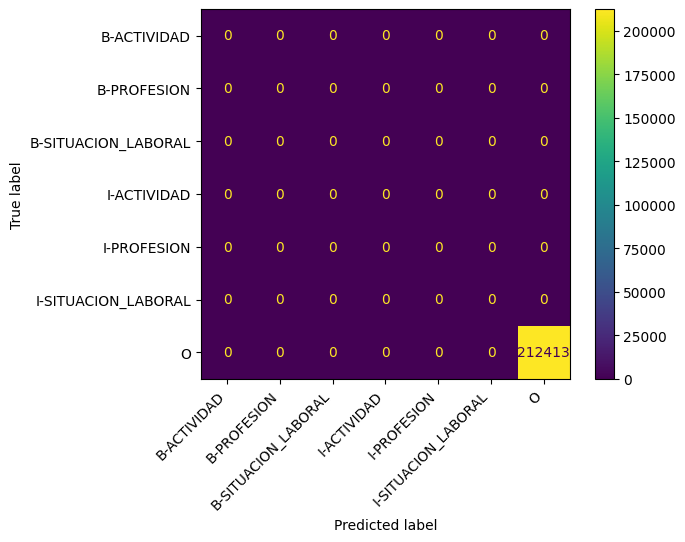

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=class_labels)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

https://pypi.org/project/nervaluate/

In [31]:
len(gs)

344

In [33]:
from nervaluate import Evaluator
evaluator = Evaluator(gs, pred, tags=['FAMILIAR', 'SANITARIO', 'OTROS', 'PACIENTE'], loader="list")
#evaluator = Evaluator(gs, pred, tags=['PROFESION', 'SITUACION_LABORAL', 'ACTIVIDAD'], loader="list")
results, results_by_tag = evaluator.evaluate()
print(results)


{'ent_type': {'correct': 894, 'incorrect': 51, 'partial': 0, 'missed': 136, 'spurious': 123, 'possible': 1081, 'actual': 1068, 'precision': 0.8370786516853933, 'recall': 0.8270120259019427, 'f1': 0.8320148906468126}, 'partial': {'correct': 847, 'incorrect': 0, 'partial': 98, 'missed': 136, 'spurious': 123, 'possible': 1081, 'actual': 1068, 'precision': 0.8389513108614233, 'recall': 0.8288621646623496, 'f1': 0.8338762214983713}, 'strict': {'correct': 803, 'incorrect': 142, 'partial': 0, 'missed': 136, 'spurious': 123, 'possible': 1081, 'actual': 1068, 'precision': 0.75187265917603, 'recall': 0.7428307123034228, 'f1': 0.7473243369008841}, 'exact': {'correct': 847, 'incorrect': 98, 'partial': 0, 'missed': 136, 'spurious': 123, 'possible': 1081, 'actual': 1068, 'precision': 0.7930711610486891, 'recall': 0.7835337650323775, 'f1': 0.7882736156351793}}


In [34]:
print(results_by_tag)

{'FAMILIAR': {'ent_type': {'correct': 35, 'incorrect': 9, 'partial': 0, 'missed': 8, 'spurious': 11, 'possible': 52, 'actual': 55, 'precision': 0.6363636363636364, 'recall': 0.6730769230769231, 'f1': 0.6542056074766355}, 'partial': {'correct': 38, 'incorrect': 0, 'partial': 6, 'missed': 8, 'spurious': 11, 'possible': 52, 'actual': 55, 'precision': 0.7454545454545455, 'recall': 0.7884615384615384, 'f1': 0.766355140186916}, 'strict': {'correct': 31, 'incorrect': 13, 'partial': 0, 'missed': 8, 'spurious': 11, 'possible': 52, 'actual': 55, 'precision': 0.5636363636363636, 'recall': 0.5961538461538461, 'f1': 0.5794392523364486}, 'exact': {'correct': 38, 'incorrect': 6, 'partial': 0, 'missed': 8, 'spurious': 11, 'possible': 52, 'actual': 55, 'precision': 0.6909090909090909, 'recall': 0.7307692307692307, 'f1': 0.7102803738317757}}, 'SANITARIO': {'ent_type': {'correct': 286, 'incorrect': 2, 'partial': 0, 'missed': 5, 'spurious': 5, 'possible': 293, 'actual': 293, 'precision': 0.976109215017064